# Import statements 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pathlib
import requests
import re
import psutil
%load_ext pycodestyle_magic
%pycodestyle_on
%pycodestyle_off

# Function definitions

In [2]:
def prep_db(file, file_type):
    '''
    This module reads and prepares the db : cleans,
    deletes the columns with 'Unnamed' values,
    fills NaN values
    input :
    file # the movieset file
    file type # csv file type
    output :
    df # read movie set dataframe
    '''
    if file_type == 'csv':
        df = pd.read_csv(file, sep=';', dtype=str)  # Read CSV File
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.fillna('')  # clean the data - get rid of NaN
    df = df.astype(str)  # change the default data type to string
    return(df)


def combine_row_text(features, df):
    '''
    This module combines text columns and sets
    the case of the combined text to lower
    args :
    input :
    features # list of database columns to search in the movies database
    df # pandas dataframe
    output : counts # dataframe
    '''
    df['comb'] = ''
    for feature in features:
        df['comb'] = df['comb'].str.cat(df[feature].copy(), sep=',')
    df['comb'] = df['comb'].str.lower()
    return(df)


def highest_count_words(df):
    '''
    This module takes as input the imported movie dataset
    and counts the occurance of the words and
    sets the columns in decreasing order
    args :
    input : df # pandas dataframe of the imported movie dataset
    output : counts # dataframe of the counted words
    '''
    count_matrix = vectorizer.fit_transform(df.keywords)
    count_matrix = count_matrix.astype(np.int32)
    counts = pd.DataFrame(count_matrix.toarray(),
                          index=df.title,
                          columns=vectorizer.get_feature_names())
    return(counts)


def find_delete_columns(counts, character, char):
    '''
    This module is run off of the delete columns mega
    and deletes the unwanted columns of words
    args :
    input :
    counts # dataframe of column of counted words
    character # regex code for the particular character(s)
    char # the unwanted character(s) that I want deleted
    output :
    counts # dataframe without the unwanted characters
    '''
    t = 0  # column counter
    n = 1
    orig = len(counts.columns)
    print(f'removing {char} .... ')
    for i in counts.columns:
        if t == (n * 1000):
            # print(str(round(t/len(counts.columns)*100,0))+'%')
            n += 1
        t += 1
        if re.findall(character, i):
            del counts[i]
    return(counts)


def most_frequent_words(counts):
    '''
    This module prepares the most frequent words of the
    specific movie's selection types and ouputs to a csv
    input :
    counts # dataframe of column of counted words
    output :
    counts_transposed # column transferred to rows
    and saved to a csv
    '''
    counts_transposed = counts.T
    counts_transposed['sum'] = counts_transposed.sum(axis=1)
    cols = counts_transposed.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    counts_transposed = counts_transposed.astype(np.int32)
    counts_transposed = counts_transposed[cols]
    counts_transposed = counts_transposed.sort_values(by=['sum'],
                                                      axis=0, ascending=False)
    movie_counts = counts_transposed
    most_frequent_words = counts_transposed[['sum']]
    most_frequent_words = most_frequent_words.reset_index()
    most_frequent_words = most_frequent_words.rename(columns={'index': 'word',
                                                              'sum':'frequency'}, index={'title': 'index'})
    return(most_frequent_words,counts_transposed)


def cloud_word(word, nr_of_movies, movie_counts):
    var = word
    df = movie_counts.T[[var]]
    return(df.sort_values(var, ascending=False).head(nr_of_movies))

def make_pandas(freq_words, nr_of_movies, movie_counts):
    '''
    construct pandas from frequently used words,
    crossed with number of movies, per keyword row count
    args :
    input :
    freq_words # frequently used words
    nr_of_movies # max number of recommendations
    movie_counts # keyword row count
    output :
    df # movie recommendations
    '''
    word_list = freq_words['word']
    word_list = word_list.tolist()
    t = 0
    for i in word_list:
        movies = cloud_word(i, nr_of_movies, movie_counts)
        movies = movies[1:]
        movies = movies.reset_index()
        movies = pd.DataFrame(data=movies)
        movies = movies.rename(columns={'title':i})
        movies = movies.iloc[:, :-1]
        if t == 0:
            df1 = movies
        elif t> 1:
            df1 = pd.concat([df1,movies], axis=1)
        t+=1
    return(df1)

        
def word_cloud(wrds):
    '''
    The function is the word cloud generator
    Input : colunms of title and keywords of words and
    groups of words from the db.
    Output : the word cloud graphic
    '''
    print(wrds)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width=500, height=500,
                          background_color='white',
                          stopwords=stopwords,
                          random_state=None,
                          min_font_size=15).generate(','.join(wrds))
    #  plot the WordCloud image
    plt.figure(figsize=(10, 10), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(MAIN_FOLDER + MWML_FOLDER + 'word_cloud_graphic.png')
    plt.tight_layout(pad=0)
    plt.show()

# Main functions

In [3]:
vectorizer = CountVectorizer(stop_words='english')
'''
Imports the 44,000 movie database into
a pandas df so you can retrieve the columns.
There are 24 columns in the database ranging
from keywords to director.
'''
# Load the dataframe
MAIN_FOLDER = 'c:/Users/champ/Python_proj/'
MWML_FOLDER = 'made_with_ml_repo/temp/moviebuddy/meta_data/'
FILE = "filtered.csv"

df = prep_db(MAIN_FOLDER + MWML_FOLDER + FILE, 'csv')
df = df[['title', 'keywords']]

#  df = df.head(38000)
df['keywords'] = df['keywords'].str.replace(', ', ',')
df['keywords'] = df['keywords'].str.replace("\s", '_')
print('The selection types are : ')
print(df.info())

print(f'RAM = {psutil.virtual_memory().percent}')

# Main functions
# counts all theindividual words in the title and the keywords
counts = highest_count_words(df)

# organizes the word count
frequent_words, movie_counts = most_frequent_words(counts)
print(display(frequent_words.head(10)))
movies = make_pandas(freq_words=frequent_words.head(50),
                     nr_of_movies=20, movie_counts=movie_counts)
movies.to_csv(MAIN_FOLDER + MWML_FOLDER +
              'word_cloud_movie_recommendations.csv',
              index=False, header=True, sep=';')

The selection types are : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45416 entries, 0 to 45415
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     45416 non-null  object
 1   keywords  45416 non-null  object
dtypes: object(2)
memory usage: 709.8+ KB
None
RAM = 37.0


title,word,frequency
0,woman_director,3038
1,independent_film,1914
2,murder,1285
3,based_on_novel,822
4,musical,726
5,sex,684
6,violence,647
7,nudity,629
8,revenge,618
9,biography,613


None


# Word cloud

0                       superhero,lego
1        nature,science,canadian_movie
2                    vietnam_war,short
3                                     
4                      stand-up_comedy
                     ...              
45411                                 
45412          blacksmith,beer,workmen
45413                            short
45414               dancer,silent_film
45415                                 
Name: keywords, Length: 45416, dtype: object


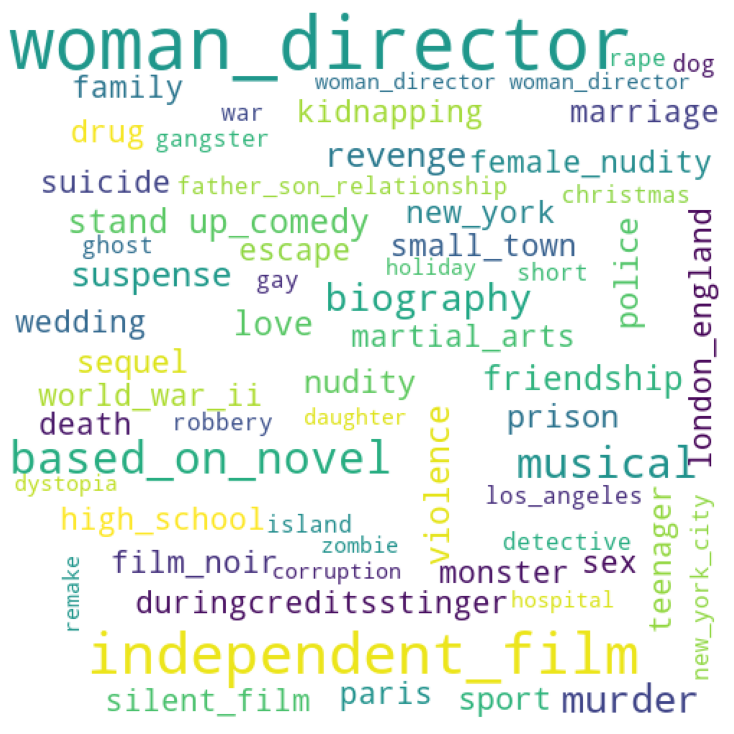

In [4]:
'''
A word cloud is generated here based on the occurance of keyword words
'''
word_cloud(df['keywords'])

In [6]:
movies

,woman_director,murder,based_on_novel,musical,sex,violence,nudity,revenge,biography,suspense,...,gay,marriage,christmas,death,gangster,gore,zombie,small_town,detective,london_england
0,Advanced Style,The Revenant,Disgrace,The Three Musketeers,Love Object,Fatal Bond,Happy Campers,Shutter,Greater,Dead Again,...,Bad Education,Transistor Love Story,Christmas on Mars,The Legend of Paul and Paula,Black Friday,Xtro,Patient Zero,Edward Scissorhands,Fallen,Pool of London
1,Elegy,Blindside,Moby Dick,Into the Woods,Edmond,A Serbian Film,Summer Lovers,In the Name of the King: A Dungeon Siege Tale,Against the Ropes,Above Suspicion,...,Esteros,On Guard,A Christmas Carol,Waking the Dead,The General,Possession,Trancers,Killer Movie,The Caller,Metroland
2,The Falling,Martyrs,The Time Traveler's Wife,Sleeping Beauty,Dangerous Invitations,A Deadly Adoption,The Doors,Bastards,Life,The Boy Next Door,...,Weekend,Antichrist,A Christmas Carol,Wilderness,A Bullet for Joey,Texas Chainsaw 3D,Resident Evil: Afterlife,Spellbound,The Medallion,We Still Kill the Old Way
3,Bluebeard,Road Games,Invasion of the Body Snatchers,Sleeping Beauty,FM,The Revenant,Psycho III,T2 Trainspotting,Christine,True Crime,...,Make the Yuletide Gay,Bliss,Donovan's Reef,Toni Erdmann,The Ice Harvest,Altered,Revenge of the Zombies,Only the Young,The Living Dead at Manchester Morgue,Shooting Fish
4,Men with Guns,Wreckage,Gone Baby Gone,The Three Musketeers,The Boy Next Door,No Mercy,Arachnia,Hamlet,Malcolm X,4bia,...,The Phantom,Today We Live,A Nanny for Christmas,Ten Canoes,Gloria,The Windmill Massacre,Zombie Pizza,Bye Bye Birdie,Angel,Mr. Holmes
5,Double Dare,The Boys Next Door,The Great Man,Stingray Sam,Dream for an Insomniac,Sexy Beast,Last Night,Heaven's Prisoners,Loving,Deceived,...,Mr. Right,War and Peace,Cover Up,The Evening Star,The Evil That Men Do,The Ordeal,Night of the Living Dead,"Happy, Texas",Shadow of a Doubt,Tomorrow Never Dies
6,Men with Guns,BreadCrumbs,The Lost,Frozen,The Invisible Maniac,Edmond,Fortress,Raw Edge,Orson Welles: Shadows & Light,The Phone Box,...,Tarnation,RV,Daylight,Tum Bin,Villain,13 Eerie,Night of the Living Dead,Charley Varrick,Feed,The Man Who Knew Too Little
7,In the Land of Blood and Honey,Bullies,Backlash,Kiki,Trash Fire,Cut Bank,Into the Forest,Altered,Temple Grandin,Asylum,...,Tumbledown,Pleasure Cruise,A Christmas Kiss,Drishyam,Forbidden,Jack O,Resident Evil: Damnation,Seedpeople,Witness,Roald Dahl's Esio Trot
8,"Eila, Rampe ja Likka",Anything for Her,Aparajito,A Chorus Line,Eugenie,Looper,Cabin Fever,A Bittersweet Life,Endgame,11:59,...,Paternity Leave,Anna Karenina,The Snowman,The Omen,Mickey One,GoodFellas,Raw Force,The Killers,Gang Related,B. Monkey
9,A Crush on You,Frequency,1984,The Lure,Cheech & Chong's Animated Movie,Stray Cat Rock: Delinquent Girl Boss,Things You Can Tell Just by Looking at Her,Moby Dick,The Philadelphia Experiment,Down the Shore,...,Norman... Is That You?,Prague,The Fitzgerald Family Christmas,Manchester by the Sea,Gangster Squad,Flesh Eating Mothers,Sugar Hill,The Vicious Kind,Hollywoodland,Flushed Away
